# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 59.2 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=34e71386d18c9ef8089610bd71c0c544903a1db18071dea8f66bc19bf6e75454
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=996ddba306f96f2f9867f0af77a1650d8d51a751dcd861cd6a989946ad3f6a57
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (3/3), done.


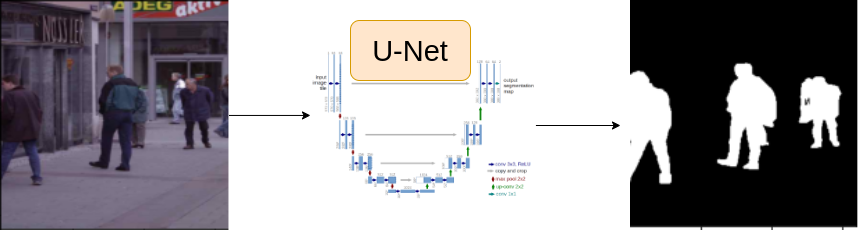

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE="/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR="/content/"
EPOCHS=25
BATCH_SIZE=16
IMAGE_SIZE=320
LR=0.003
ENCODER="timm-efficientnet-b0"
WEIGHTS="imagenet"
DEVICE="cuda"

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

masks  \
0  Human-Segmentation-Dataset-master/Ground_Truth...   
1  Human-Segmentation-Dataset-master/Ground_Truth...   
2  Human-Segmentation-Dataset-master/Ground_Truth...   
3  Human-Segmentation-Dataset-master/Ground_Truth...   
4  Human-Segmentation-Dataset-master/Ground_Truth...   

                                              images  
0  Human-Segmentation-Dataset-master/Training_Ima...  
1  Human-Segmentation-Dataset-master/Training_Ima...  
2  Human-Segmentation-Dataset-master/Training_Ima...  
3  Human-Segmentation-Dataset-master/Training_Ima...  
4  Human-Segmentation-Dataset-master/Training_Ima...

In [7]:
row=df.iloc[5]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0


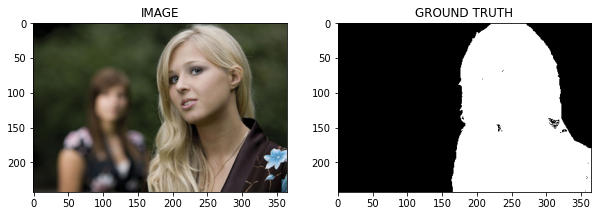

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [35]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)],is_check_shapes=False)
def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),],is_check_shapes=False)  

# Task 4 : Create Custom Dataset 

In [36]:
from torch.utils.data import Dataset

In [37]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']
      #(h,w,c)-->(c,h,w)

      image=np.transpose(image,(2,0,1)).astype(np.float32)
      mask=np.transpose(mask,(2,0,1)).astype(np.float32)

      image=torch.Tensor(image)/255.0
      mask=torch.round(torch.Tensor(mask)/255.0)

      return image,mask


    



In [38]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(test_df,get_valid_augs())

In [39]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


/content/Human-Segmentation-Dataset-master/helper.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


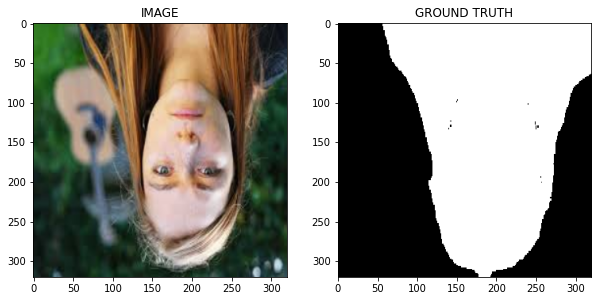

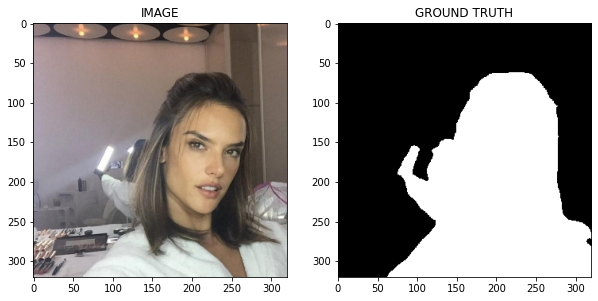

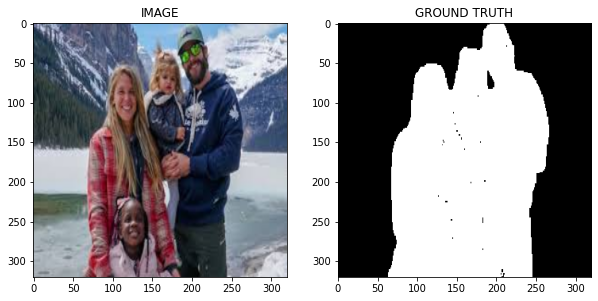

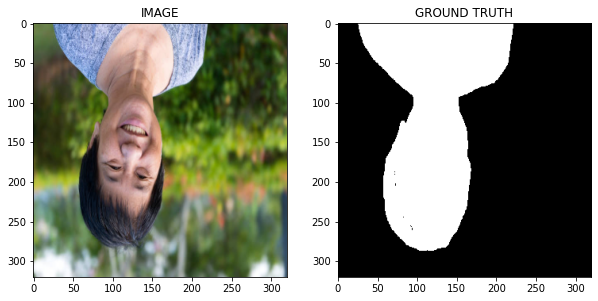

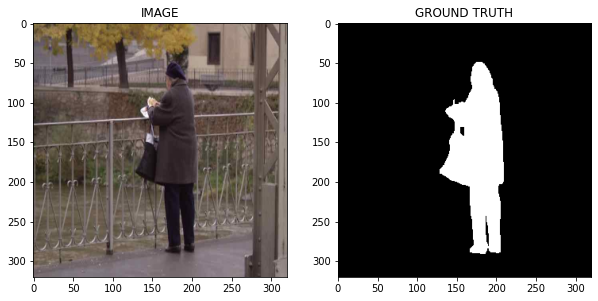

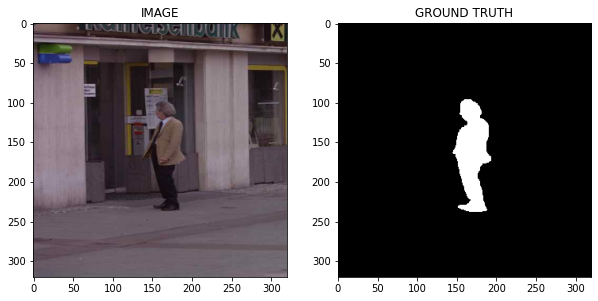

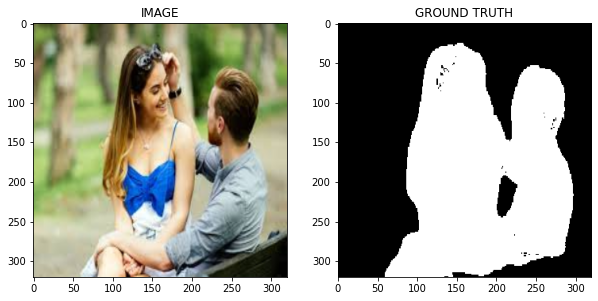

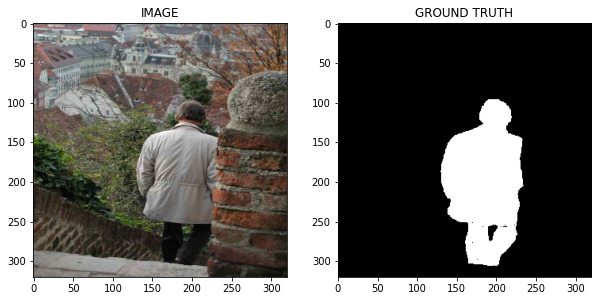

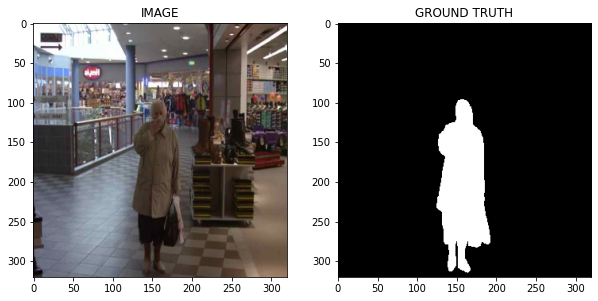

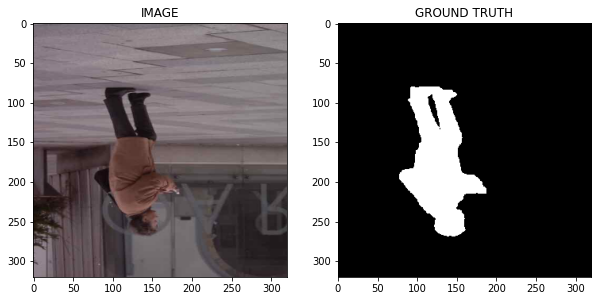

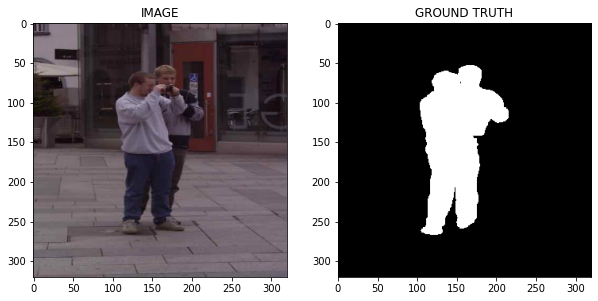

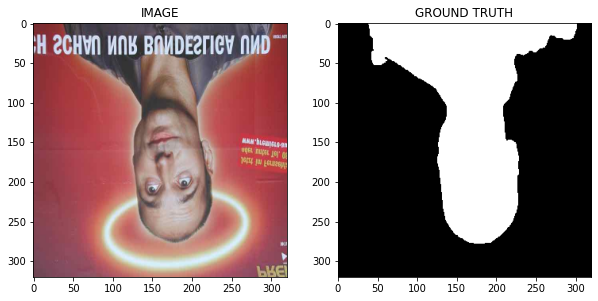

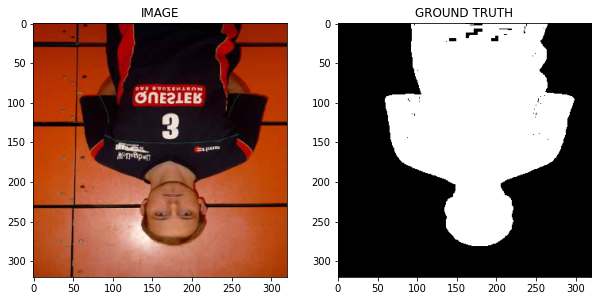

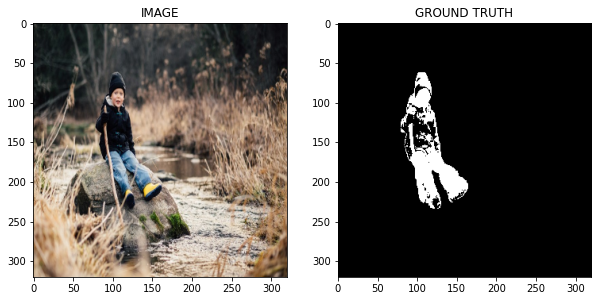

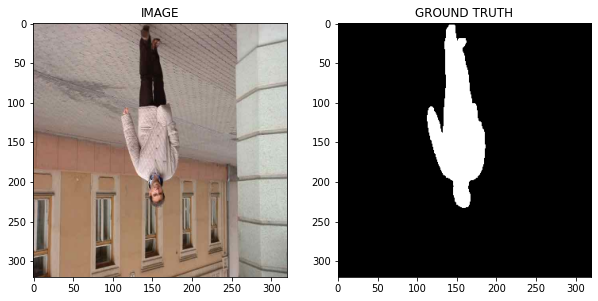

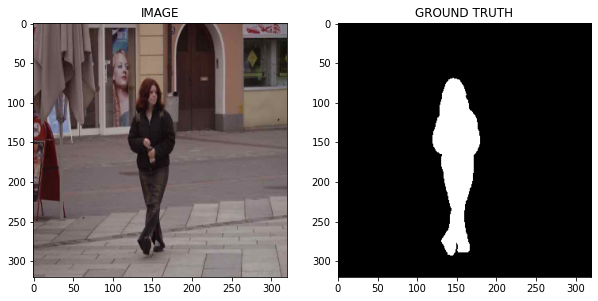

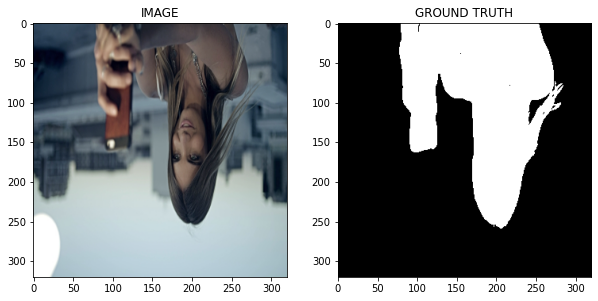

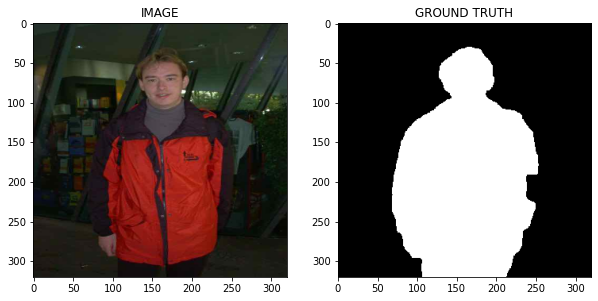

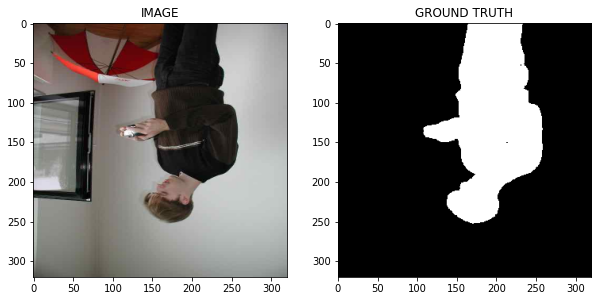

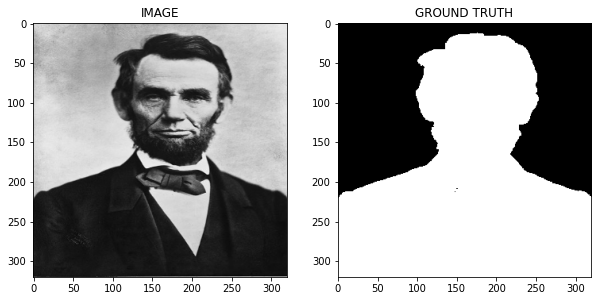

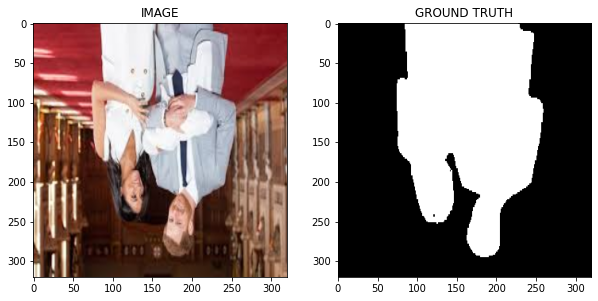

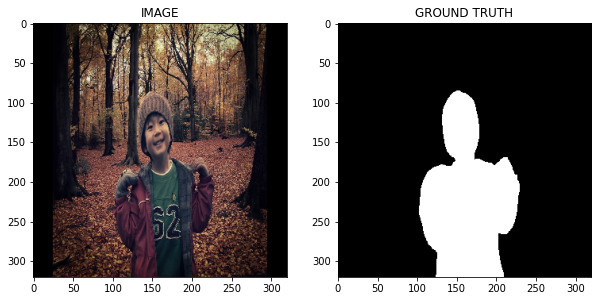

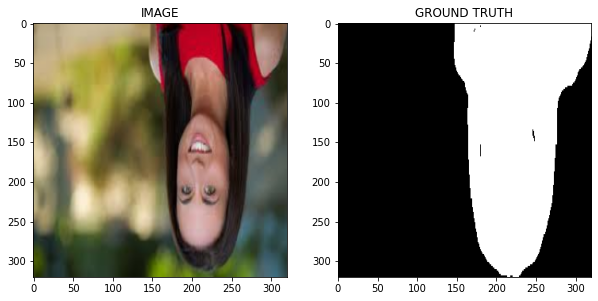

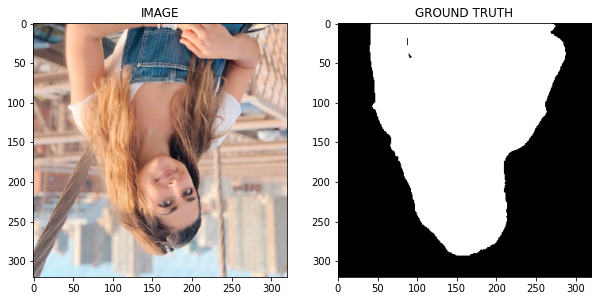

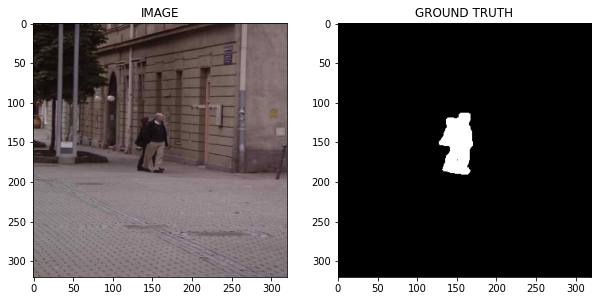

In [46]:
for i in range(25):
  imagee,mask=trainset[i]
  helper.show_image(imagee,mask)

# Task 5 : Load dataset into batches

In [47]:
from torch.utils.data import DataLoader

In [48]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [49]:
print(f"nb batches of train: {len(trainloader)}")
print(f"nb batches of valid: {len(validloader)}")

nb batches of train: 15
nb batches of valid: 4


In [50]:
for image,mask in trainloader:
  break
print(f"one batch of image shape{image.shape}")  
print(f"one batch of mask shape{mask.shape}")  

one batch of image shapetorch.Size([16, 3, 320, 320])
one batch of mask shapetorch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [51]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [52]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(encoder_name=ENCODER,encoder_weights=WEIGHTS,in_channels=3,classes=1,activation=None)
  def forward(self,images,masks=None):
    logits=self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1+loss2
    return logits    

In [53]:
model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [58]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0
  for images,masks in tqdm(data_loader):
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  return total_loss/len(data_loader)  

In [59]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      logits,loss=model(images,masks)

      total_loss+=loss.item()
  return total_loss/len(data_loader)  

# Task 8 : Train Model

In [60]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [61]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("Saved model")
    best_valid_loss=valid_loss
  print(f"EPOCH:{i+1} train loss:{train_loss} valid_loss:{valid_loss}")  


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Saved model
EPOCH:1 train loss:0.749165294567744 valid_loss:1.056849405169487


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


EPOCH:2 train loss:0.37342530290285747 valid_loss:1.215487316250801


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Saved model
EPOCH:3 train loss:0.3304649541775386 valid_loss:0.37607500329613686


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Saved model
EPOCH:4 train loss:0.2989964097738266 valid_loss:0.290290504693985


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Saved model
EPOCH:5 train loss:0.24956974188486736 valid_loss:0.24197929352521896


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


EPOCH:6 train loss:0.2342332621415456 valid_loss:0.2735397703945637


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Saved model
EPOCH:7 train loss:0.2110764314730962 valid_loss:0.23737243935465813


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


EPOCH:8 train loss:0.19918687144915262 valid_loss:0.2583497539162636


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


EPOCH:9 train loss:0.18409095307191212 valid_loss:0.3283233791589737


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


EPOCH:10 train loss:0.198196479678154 valid_loss:0.272250734269619


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


EPOCH:11 train loss:0.15924036204814912 valid_loss:0.3048662580549717


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


EPOCH:12 train loss:0.16391290624936422 valid_loss:0.3584301844239235


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Saved model
EPOCH:13 train loss:0.13969570100307466 valid_loss:0.18375849723815918


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


EPOCH:14 train loss:0.12037684073050817 valid_loss:0.2110014110803604


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


EPOCH:15 train loss:0.1238010307153066 valid_loss:0.20577089488506317


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


EPOCH:16 train loss:0.15458004424969354 valid_loss:0.24315889552235603


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


EPOCH:17 train loss:0.14742583880821863 valid_loss:0.2934367507696152


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


EPOCH:18 train loss:0.13477032879988352 valid_loss:0.2124408408999443


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


EPOCH:19 train loss:0.12890155563751857 valid_loss:0.24104999378323555


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


EPOCH:20 train loss:0.12281622936328253 valid_loss:0.23655812442302704


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


EPOCH:21 train loss:0.10079717487096787 valid_loss:0.18790649436414242


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


EPOCH:22 train loss:0.1087075928846995 valid_loss:0.26442357897758484


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


EPOCH:23 train loss:0.10013716916243236 valid_loss:0.18722863867878914


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Saved model
EPOCH:24 train loss:0.0953423336148262 valid_loss:0.17492124438285828


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

EPOCH:25 train loss:0.08489160339037577 valid_loss:0.1855395846068859


# Task 9 : Inference

In [78]:
my_pic=cv2.imread('/content/couples-kitchen-make-love-Favim.com-6057491.jpg')
my_pic = cv2.resize(my_pic, (320, 320))

my_pic=cv2.cvtColor(my_pic,cv2.COLOR_BGR2RGB)
my_pic=np.transpose(my_pic,(2,0,1)).astype(np.float32)

my_pic=torch.Tensor(my_pic)/255.0

In [79]:
idx=54

model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]
logits_mask=model(my_pic.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

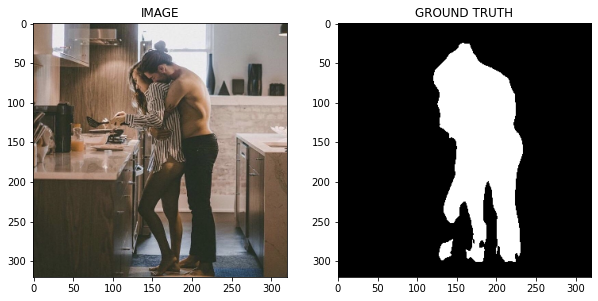

In [80]:
helper.show_image(my_pic,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya